# Labels Addition

This notebook adds labels to spectra and makes some statistics about classes.

In [1]:
import numpy as np
import collections
import math
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [2]:
LABELS_FILE = 'data/ondrejov-labeled-spectra.csv'
!head $LABELS_FILE

id,label
ivo://asu.cas.cz/stel/ccd700/uc050029,2
ivo://asu.cas.cz/stel/ccd700/sd150065,1
ivo://asu.cas.cz/stel/ccd700/oj140028,1
ivo://asu.cas.cz/stel/ccd700/a201510030016,0
ivo://asu.cas.cz/stel/ccd700/wd240048,2
ivo://asu.cas.cz/stel/ccd700/ml090037,0
ivo://asu.cas.cz/stel/ccd700/wc290009,0
ivo://asu.cas.cz/stel/ccd700/vb120025,1
ivo://asu.cas.cz/stel/ccd700/ue080044,0


In [3]:
# load labels
labeled_idents = np.genfromtxt(
    LABELS_FILE,
    delimiter=',',   # CSV file
    dtype=None,      # guess dtypes automatically
    skip_header=1    # first he
)
total = labeled_idents.shape[0]
total

13335

## Counts

Make bar chart to see structure of the dataset.

In [4]:
counts = collections.Counter(map(lambda x: x[1], labeled_idents))
counts

Counter({0: 5301, 1: 6103, 2: 398, 3: 1533})

In [5]:
for label, cnt in counts.items():
    percents = cnt / total * 100
    print('{} is {}%'.format(label, round(percents, 2)))

0 is 39.75%
1 is 45.77%
2 is 2.98%
3 is 11.5%


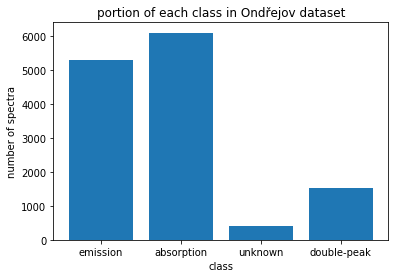

In [6]:
idx = np.arange(len(counts))
rects = plt.bar(idx, counts.values())
plt.xticks(idx, ('emission', 'absorption', 'unknown', 'double-peak'))
plt.ylabel('number of spectra')
plt.xlabel('class')
plt.title('portion of each class in Ondřejov dataset');
# https://matplotlib.org/examples/api/barchart_demo.html
#for rect in rects:
#    height = rect.get_height()
#    plt.text(
#        rect.get_x() + rect.get_width() / 2, height,
#        '{}'.format(int(height)),
#        ha='center', va='bottom'
#    )

## Classes Preview

In [7]:
f = h5py.File('data/data.hdf5')
spectra = f['spectra']

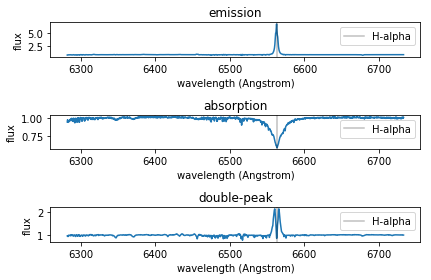

In [8]:
def plot_class(spectrum, ax, class_name):
    ax.plot(spectrum[0, :], spectrum[1, :])
    ax.set_title(class_name)
    ax.set_xlabel('wavelength (Angstrom)')
    ax.axvline(x=6562.8, color='black', label='H-alpha', alpha=0.25)
    ax.legend()
    ax.set_ylabel('flux')

f, axs = plt.subplots(3, 1)
plot_class(spectra['lb160035'], axs[0], 'emission')
plot_class(spectra['a201403300026'], axs[1], 'absorption')
plot_class(spectra['si220021'], axs[2], 'double-peak')
plt.tight_layout();

# Let's Add Labels

Add labels to the HDF5 file.

In [9]:
for ident, label in labeled_idents:
    ident = ident.decode('ascii').split('/')[-1]
    spectra[ident].attrs['label'] = label

## Vizualize All Spectra in a Class

In [10]:
def plot_all_in_class(label):
    for ident, data in spectra.items():
        if spectra[ident].attrs['label'] == label:
            plt.plot(data[0], data[1], alpha=0.1, lw=0.5)

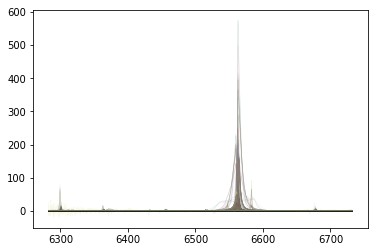

In [11]:
# emission
plot_all_in_class(0)

There are some novas in emissions.

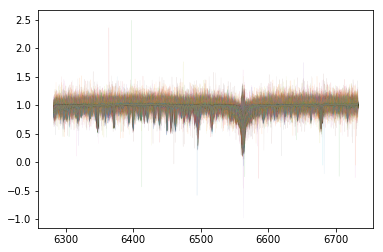

In [12]:
# absorption
plot_all_in_class(1)

Here are some peaks in the middle.
But I think they are not significant.

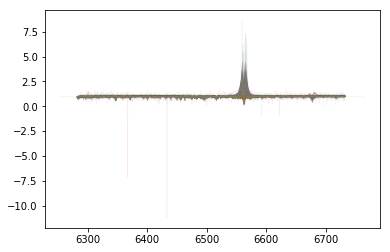

In [13]:
# double-peak
plot_all_in_class(3)

## Wavelength Ranges

In [14]:
# find spectrum which start with highest value
# x is tuple x[1] are values, [0, 0] is first wavelength
wave_starts = dict(map(lambda x: (x[0], x[1][0, 0]), spectra.items()))

(array([  1.00000000e+00,   1.32040000e+04,   1.50000000e+01,
          0.00000000e+00,   0.00000000e+00,   1.11000000e+02,
          0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([ 6252.90917969,  6279.46098633,  6306.01279297,  6332.56459961,
         6359.11640625,  6385.66821289,  6412.22001953,  6438.77182617,
         6465.32363281,  6491.87543945,  6518.42724609]))

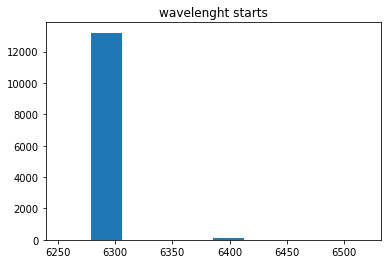

In [15]:
starts_n, starts_bins, _ = plt.hist(list(wave_starts.values()))
plt.title('wavelenght starts')
starts_n, starts_bins

## Infimum

This analysis shows that the infimum from starting wavelengths is 6518.4272.
That is pretty high but H-alpha is 6562.8 and H-alpha is the main feature. 
It may shorten the range of value and thus speed up training.
I also reviewed some spectra and it is far enough from H-alpha.
Therefore **6519 Angstrom** should be choosen as staring wavelength.

In [16]:
infimum = list(reversed(sorted(wave_starts.items(), key=lambda x: x[1])))[0][1]
print('infimum:', math.ceil(infimum))

infimum: 6519


In [17]:
list(reversed(sorted(wave_starts.items(), key=lambda x: x[1])))[:10]

[('la220044', 6518.4272),
 ('a201504060008', 6491.1357),
 ('a201504060037', 6490.8672),
 ('td210007', 6454.3965),
 ('qd260023', 6411.4692),
 ('qd120025', 6409.8438),
 ('a201407220020', 6407.2817),
 ('pk230012', 6406.8813),
 ('pk230013', 6406.8809),
 ('pk230010', 6406.8804)]

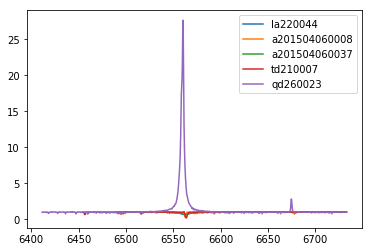

In [18]:
def plot_spectrum(ident):
    spectrum = spectra[ident]
    plt.plot(spectrum[0], spectrum[1], label=ident)

plot_spectrum('la220044')
plot_spectrum('a201504060008')
plot_spectrum('a201504060037')
plot_spectrum('td210007')
plot_spectrum('qd260023')
plt.legend();

In [19]:
# find spectrum which end with lowest value
# x is tuple x[1] are values, [0, 0] is first wavelength
wave_ends = dict(map(lambda x: (x[0], x[1][0, -1]), spectra.items()))

(array([  1.33340000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 6732.74316406,  6735.99277344,  6739.24238281,  6742.49199219,
         6745.74160156,  6748.99121094,  6752.24082031,  6755.49042969,
         6758.74003906,  6761.98964844,  6765.23925781]))

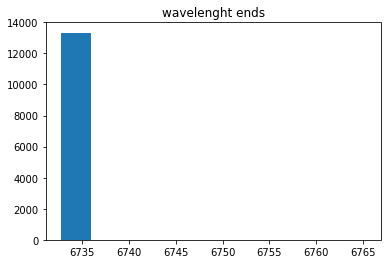

In [20]:
ends_n, ends_bins, _ = plt.hist(list(wave_ends.values()))
plt.title('wavelenght ends')
ends_n, ends_bins

## Supremum

At ends there is no problem because most of spectra are is first bar.

In [21]:
supremum = list(sorted(wave_ends.items(), key=lambda x: x[1]))[0][1]
print('supremum:', math.floor(supremum))

supremum: 6732


In [22]:
list(sorted(wave_ends.items(), key=lambda x: x[1]))[:10]

[('pb060015', 6732.7432),
 ('nk240012', 6732.7437),
 ('wd250070', 6732.7437),
 ('pj090030', 6732.7437),
 ('lb160035', 6732.7437),
 ('pi100014', 6732.7437),
 ('vh200045', 6732.7437),
 ('vi280028', 6732.7437),
 ('wd250071', 6732.7437),
 ('vd040011', 6732.7437)]

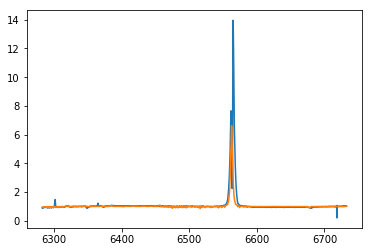

In [23]:
plot_spectrum('pb060015')
plot_spectrum('lb160035')

## Number of Wavelength Points

This is nice but depend on wavelen range.
Density would be better

In [24]:
wave_len = dict(map(lambda x: (x[0], x[1].shape[-1]), spectra.items()))
wave_len_sorted = sorted(wave_len.items(), key=lambda x: x[1])

In [25]:
wave_len_sorted[:5], wave_len_sorted[-5:]

([('la220044', 837),
  ('a201504060008', 1048),
  ('a201504060037', 1049),
  ('td210007', 1086),
  ('qd260023', 1254)],
 [('a201402150015', 1954),
  ('a201403130079', 1954),
  ('a201310020032', 1954),
  ('a201404120022', 1954),
  ('we200016', 1997)])

## Wavelength Points Density

This is much better density on average is one data point per 0.249 Angstroms.
Standard deviation is small 0.0119.

In [26]:
wave_density = {
    ident: (wave_ends[ident] - wave_starts[ident]) / cnt
    for ident, cnt in wave_len.items()
}

In [27]:
# minimal and maximal density
min(wave_density.values()), max(wave_density.values())

(0.23060327171711154, 0.25669766070156697)

In [28]:
# mean and standard deviation
np.mean(list(wave_density.values())), np.std(list(wave_density.values()))

(0.24861943389436353, 0.011874111598557977)